## 1.  Data Fitting vs. Sparsity Tradeoff. 

This assignment uses the dataset BreastCancer.mat to explore sparse regularization of a least squares problem. The journal article “A gene-expression signature as a predictor of survival in breast cancer” provides background on the role of genes in breast cancer. The goal is to solve the Lasso problem $w∗= argmin_{w∈R^n} ‖Aw−d‖_2^2+λ‖w‖_1$ Here $w$ is the weight vector applied to the expression levels of 8141 genes and there are 295 patients (feature sets and labels).  In this problem we will vary $λ$ to explore the tradeoff between data-fitting and sparsity. Scripts  that  implement  iterative  soft  thresholding  via  proximal  gradient  descent  to solve  the  LASSO  problem  are  available.   The  scripts  use  a  hot  start  procedure  for finding the solution with different values for $λ$.  The initial guess for the next value of $λ$ is the converged solution for the preceding value.  This accelerates convergence when subsequent values of $λ$ lead to similar solutions.

a)  Write code to find the optimal weights using only the first 100 patients (first 100 rows).  Create a plot with the residual $‖Aw^* −d‖_2$ on the vertical-axis and $‖w^*‖_1$ on the horizontal-axis, parameterized by $λ$.  In other words, create the curve by finding $w^∗$ for different $λ$, and plotting $‖w^∗‖_1$ vs. $‖Aw^* −d‖_2$.  Experiment with $λ$ to find a range that captures the variation from the least-squares solution (small $λ$) to the all zeros solution (large $λ$).  Appropriate values of $λ$ may range from $10^−6$ to 20, spaced logarithmically.  Explain the result.

In [1]:
from scipy.io import loadmat
import numpy as np
X = loadmat("BreastCancer.mat")['X']
y = loadmat("BreastCancer.mat")['y']

In [2]:
def ista_solve_hot(A,d,la_array):
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w
            
            if np.linalg.norm(w - w_old) < tol:
                break
    return X

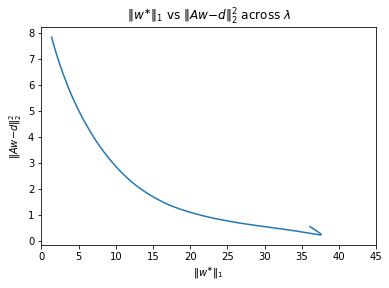

In [3]:
num = 100
lam_vals = np.logspace(np.log10(1e-6), np.log10(20), num, endpoint= True)

# Use training data to learn classifier
X_partial = X[:100,:]
y_partial = y[:100]
W = ista_solve_hot(X_partial,y_partial,lam_vals)


n_1 = np.linalg.norm(W, 1, axis = 0)
n_2 = np.linalg.norm(X_partial @ W - y_partial, 2, axis = 0)

import matplotlib.pyplot as plt 

plt.plot(n_1, n_2)
plt.title(r'$‖w^∗‖_1$' + " vs " + r'$ ‖Aw−d‖_2^2 $' + " across " + r'$λ$')
plt.xlabel(r'$‖w^∗‖_1$')
plt.ylabel(r'$‖Aw−d‖_2^2$')
plt.xlim(0,45)
plt.show()

#### => The higher $λ$ we have, the more we put weight on minimizing $‖w^*‖_1$, and vice versa. In other words, 1-norm and 2-norm is inversely proportionate.

b)  Next use your solutions from part a) to plot the error rate on the vertical-axis versus the sparsity on the horizontal-axis as $λ$ varies.  Define the error rate as the number of incorrect predictions divided by the total number of predictions and the sparsity as the number of nonzero entries in $w^∗$.  For this purpose, we’ll say an entry $w_i$ is nonzero if $|w_i|>10−6$.  Calculate the error rate using the training data,the data used to find the optimal weights.  Explain the result.

Text(0.5, 1.0, 'Sparsity vs Error rate across λ')

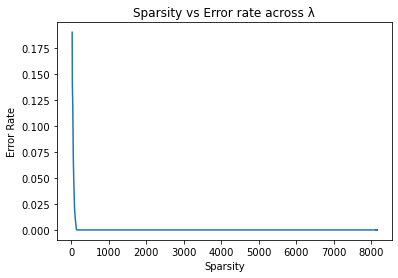

In [4]:
error_rates = []
sparsities = []
for i in range(len(lam_vals)):
    w_opt = W[:,i]
    y_hat = np.sign(X_partial @ w_opt).reshape(-1,1)
    #print(y_hat)

    error_vec = [0 if i[0]==i[1] else 1 for i in np.hstack((y_hat, y_partial))]
    error_rates.append(sum(error_vec) / len(y_hat))
 
    w_opt[abs(w_opt) <= 10**-6] = 0
    sparsity = np.count_nonzero(w_opt, axis=None)
    sparsities.append(sparsity)
    
#plt.scatter(sparsities,error_rates)
plt.plot(sparsities,error_rates)
plt.xlabel("Sparsity")
plt.ylabel("Error Rate")
plt.title("Sparsity vs Error rate across λ")

#### => Up to some  $λ$, we have many nonzero terms and error rates converges to zero. However, as  $λ$ surpasses particualr interval, the sparsity decreases and error rate increases.

c)  Repeat parts a) and b)to display the residual and error rate, respectively using validation or test data,  rows  101-295  of  the  data  matrix,  that  is,  the  data  not used to design the optimal classifier.  Again, explain what you see in each plot.

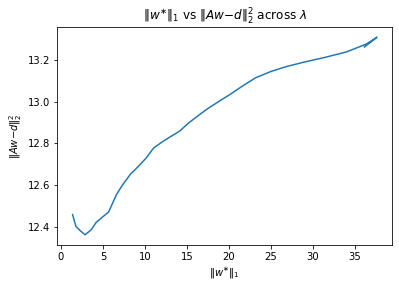

In [5]:
# Use training data to learn classifier
X_partial_2 = X[100:,:]
y_partial_2 = y[100:]

W = ista_solve_hot(X_partial,y_partial,lam_vals)

n_1 = np.linalg.norm(W, 1, axis = 0)
n_2 = np.linalg.norm(X_partial_2 @ W - y_partial_2, 2, axis = 0)

plt.plot(n_1, n_2)
plt.title(r'$‖w^∗‖_1$' + " vs " + r'$ ‖Aw−d‖_2^2 $' + " across " + r'$λ$')
plt.xlabel(r'$‖w^∗‖_1$')
plt.ylabel(r'$‖Aw−d‖_2^2$')
plt.show()

#### => Unlike the previous case, 1-norm and 2-norm is proportionate.

Text(0.5, 1.0, 'Sparsity vs Error rate across λ')

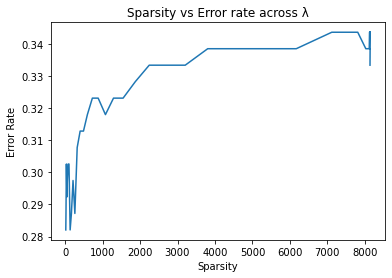

In [6]:
error_rates = []
sparsities = []
for i in range(len(lam_vals)):
    w_opt = W[:,i]
    y_hat = np.sign(X_partial_2 @ w_opt).reshape(-1,1)

    error_vec = [0 if i[0]==i[1] else 1 for i in np.hstack((y_hat, y_partial_2))]
    error_rates.append(sum(error_vec) / len(y_hat))
 
    w_opt[abs(w_opt) <= 10**-6] = 0
    sparsity = np.count_nonzero(w_opt, axis=None)
    sparsities.append(sparsity)
    
#plt.scatter(sparsities,error_rates)
plt.plot(sparsities,error_rates)
plt.xlabel("Sparsity")
plt.ylabel("Error Rate")
plt.title("Sparsity vs Error rate across λ")

#### => Unlike the previous case, as  $λ$ increases, both sparsity and error rate increase.

#### 2.Now compare the performance of the LASSO and ridge regression for the breast cancer dataset using the following steps:

- Randomly split the set of 295 patients into ten subsets of size 29-30.

- Use the data in eight of the subsets to find a solution to the Lasso optimization above and to the ridge regression problem $min_w‖Aw−d‖_2^2 + λ‖w‖_2^2$. Repeat this for a range of $λ$ values to obtain a set of solutions $w_λ$.

- Compute the prediction error using each $w_λ$ on one of the remaining two of the ten subsets.  Use the solution that has the smallest prediction error to find the best $λ$.  Note that LASSO and ridge regression will produce different best values for $λ$.

- Compute the test error on the final subset of the data for the choice of $λ$ that minimizes the prediction error. Compute both the squared error and the error rate.

Repeat  this  process  for  different  subsets  of  eight  training,  one  tuning  ($λ$)  and  one testing subsets,  and compute the average squared error and average number of mis-classifications across all different subsets. Note that you should use the identity derived in Problem 1 of the Activity 5.2 in order to speed the computation of ridge regression.

## Finding  $w_λ$ for LASSO

In [15]:
##  10-fold CV 

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]] # total 10 sets

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions

test_error_lasso = []
residuals_lasso = []
# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set / 0 ~ 30
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set / 30 ~ 59
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set / 60 ~ 294
    At = X[trn_ind,:]
    bt = y[trn_ind]

# Use training data to learn classifier
# Find best lambda value using first validation set, then evaluate
# performance on second validation set, and accumulate performance metrics
# over all cases partitions

    W_lasso = ista_solve_hot(At,bt,lam_vals)
    bv1_hat_lasso = np.sign(Av1 @ W_lasso)
    
    val_error_lasso = []
    for i in range(len(lam_vals)):
        num_errors = np.count_nonzero(bv1_hat_lasso[:,i] == np.squeeze(bv1))
        val_error_lasso.append(num_errors / len(bv1_hat_lasso))
        
    min_val_lasso = min(val_error_lasso)
    min_idx_lasso = val_error_lasso.index(min_val_lasso)
    
    bv2_hat_lasso = np.sign(Av2 @ W_lasso[:, min_idx_lasso])

    test_error_rate = np.mean(bv2_hat_lasso != bv2)
    test_error_lasso.append(test_error_rate)
    
    residual_lasso = np.linalg.norm(Av2 @ W_lasso[:, min_idx_lasso] - bv2,2)
    residuals_lasso.append(residual_lasso)
    
print("Average LASSO Error Rate: ", np.mean(test_error_lasso))
print("Average LASSO 2-norm squared error: ", np.mean(residuals_lasso))

Average LASSO Error Rate:  0.3571119038182058
Average LASSO 2-norm squared error:  27.15851149684117


## Finding  $w_λ$ for Ridge Regression

In [14]:
##  10-fold CV 

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]] # total 10 sets

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions

test_error_ridge = []
residuals_ridge = []
# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set / 0 ~ 30
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set / 30 ~ 59
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set / 60 ~ 294
    At = X[trn_ind,:]
    #print("At shape:", At.shape)
    bt = y[trn_ind]
    #print("bt shape:", bt.shape)
    
    n = len(lam_vals)
    w_ridge = np.zeros((At.T.shape[0], n))
   
    for i in range(n):
        # At @ At.T => 235 * 235 / At.T @ At => 8100 * 8100
        w_ridge[:,i] = np.squeeze(At.T @ np.linalg.inv(At @ At.T + lam_vals[i] * np.eye((At @ At.T).shape[0])) @ bt)
    
    bv1_hat_ridge = np.sign(Av1 @ w_ridge)
    
    val_error_ridge = []
    for i in range(len(lam_vals)):
        num_errors = np.count_nonzero(bv1_hat_ridge[:,i] == np.squeeze(bv1))
        val_error_ridge.append(num_errors / len(bv1_hat_ridge))
        
    min_val_ridge = min(val_error_ridge)
    min_idx_ridge = val_error_ridge.index(min_val_ridge)
    
    bv2_hat_ridge = np.sign(Av2 @ w_ridge[:, min_idx_ridge])

    test_error_rate = np.mean(bv2_hat_ridge != bv2)
    test_error_ridge.append(test_error_rate)
    
    residual_ridge = np.linalg.norm(Av2 @ w_ridge[:, min_idx_ridge] - bv2, 2)
    residuals_ridge.append(residual_ridge)

print("Average Ridge Regression Error Rate: ", np.mean(test_error_ridge))
print("Average Ridge Regression 2-norm squared error: ", np.mean(residuals_ridge))

Average Ridge Regression Error Rate:  0.38240953597275434
Average Ridge Regression 2-norm squared error:  27.74784691759517


#### => LASSO gives the better performance.